In [1]:
%pip install --quiet --upgrade jupysql ipywidgets ipympl duckdb duckdb-engine pandas matplotlib jupyterlab pyarrow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import duckdb
import pandas as pd
import ipywidgets as widgets
from matplotlib import pyplot as plt, dates, ticker
import numpy as np
%load_ext sql
%matplotlib widget
conn = duckdb.connect()
%sql conn --alias duckdb
pd.options.mode.copy_on_write = True

/home/flapkap/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
%config SqlMagic.autopandas = True
#%config SqlMagic.displaycon = False

In [4]:
%%sql
INSTALL sqlite;
LOAD sqlite;

Running query in 'duckdb'

,Success


In [5]:
%%sql
ATTACH '396162.db' AS expdb (TYPE SQLITE) ;
USE expdb.main;

Running query in 'duckdb'

,Success


In [6]:
# set some matplotlib defaults
from matplotlib.dates import DateFormatter, MinuteLocator, SecondLocator, MicrosecondLocator
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
plt.rcParams['svg.fonttype'] = 'none'
# Set the global locator and formatter
plt.rcParams['date.autoformatter.microsecond'] = '%S.%f'  # Set the global format for microsecond level
plt.rcParams['date.autoformatter.second'] = '%H:%M:%S'  # Set the global format for second level
plt.rcParams['date.autoformatter.minute'] = '%H:%M'  # Set the global format for minute level
plt.rcParams['date.autoformatter.hour'] = '%Y-%m-%d %H:%M'  # Set the global format for hour level
plt.rcParams['date.autoformatter.day'] = '%Y-%m-%d %H:%M'  # Set the global format for day level
plt.rcParams['date.autoformatter.month'] = '%Y-%m-%d %H:%M'  # Set the global format for month level
plt.rcParams['date.autoformatter.year'] = '%Y-%m-%d %H:%M'  # Set the global format for year level


In [7]:
%sql SHOW;

Running query in 'duckdb'

,database,schema,name,column_names,column_types,temporary
0,expdb,main,Message,"[message_id, related_node, network_received_at]","[BIGINT, VARCHAR, TIMESTAMP]",False
1,expdb,main,Node,"[node_deveui, node_appeui, node_appkey, board_...","[VARCHAR, VARCHAR, VARCHAR, VARCHAR, VARCHAR, ...",False
2,expdb,main,Power_Consumption,"[power_consumption_id, node_id, timestamp, cur...","[BIGINT, VARCHAR, TIMESTAMP, DOUBLE, DOUBLE, D...",False
3,expdb,main,Radio,"[radio_id, timestamp, node_id, channel, rssi]","[BIGINT, TIMESTAMP, VARCHAR, BIGINT, BIGINT]",False
4,expdb,main,Site,[name],[VARCHAR],False
5,expdb,main,Trace,"[trace_id, node_id, timestamp, message]","[BIGINT, VARCHAR, TIMESTAMP, VARCHAR]",False
6,expdb,main,Uplink_Message,"[uplink_message_id, through_gateway, gateway_r...","[BIGINT, VARCHAR, TIMESTAMP, TIMESTAMP, BIGINT...",False
7,expdb,main,sqlite_sequence,"[name, seq]","[BLOB, BLOB]",False


In [8]:
hej = %sql select message from expdb.Trace WHERE message LIKE 'TIMINGS>%'

Running query in 'duckdb'

In [9]:
hej["message"][0]

'TIMINGS> Loop: 0, Sync: 806 ms, Load: 29 ms, sensor init: 25 ms, env init: 0 ms, net init: 158083 ms, Collect: -1 ms, Exec: -1 ms, Send: 7890 ms, save config: 701 ms, Sleep: 6 s\n'

In [10]:
%sql nodes =<< select distinct * from expdb.Node

Running query in 'duckdb'

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board,failed
0,70B3D57ED005EA60,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
1,70B3D57ED005EA66,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
2,70B3D57ED005EA67,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
3,70B3D57ED005EA63,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
4,70B3D57ED005EA59,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
5,70B3D57ED005EA69,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
6,70B3D57ED005EA61,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
7,70B3D57ED005EA64,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
8,70B3D57ED005EA62,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
9,70B3D57ED005EA65,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0


In [11]:
%%sql
DESCRIBE expdb.Trace

Running query in 'duckdb'

,column_name,column_type,null,key,default,extra


In [12]:

timestamps= %sql select timestamp from expdb.Power_Consumption 
timestamps

Running query in 'duckdb'

,timestamp
0,2024-04-23 13:06:50.591813
1,2024-04-23 13:06:50.592972
2,2024-04-23 13:06:50.594101
3,2024-04-23 13:06:50.595230
4,2024-04-23 13:06:50.596359
...,...
9665936,2024-04-23 13:26:56.253888
9665937,2024-04-23 13:26:56.254986
9665938,2024-04-23 13:26:56.256115
9665939,2024-04-23 13:26:56.257244


In [13]:
%sql select node_id,count(*),min(timestamp),max(timestamp) from expdb.Power_Consumption group by node_id

Running query in 'duckdb'

,node_id,count_star(),"min(""timestamp"")","max(""timestamp"")"
0,70B3D57ED005EA65,1093882,2024-04-23 13:06:50.265231,2024-04-23 13:26:56.264487
1,70B3D57ED005EA61,1075655,2024-04-23 13:06:50.104525,2024-04-23 13:26:56.249089
2,70B3D57ED005EA67,1088028,2024-04-23 13:06:50.144577,2024-04-23 13:26:56.253958
3,70B3D57ED005EA69,1062792,2024-04-23 13:06:50.591813,2024-04-23 13:26:56.264965
4,70B3D57ED005EA63,1077700,2024-04-23 13:06:50.252038,2024-04-23 13:26:56.258343
5,70B3D57ED005EA62,1059572,2024-04-23 13:06:50.144893,2024-04-23 13:26:56.256624
6,70B3D57ED005EA59,1073207,2024-04-23 13:06:50.149463,2024-04-23 13:26:56.254755
7,70B3D57ED005EA66,1049631,2024-04-23 13:06:50.164097,2024-04-23 13:26:56.258465
8,70B3D57ED005EA64,1085474,2024-04-23 13:06:50.158813,2024-04-23 13:26:56.257972


In [14]:
deveui = "70B3D57ED005EA59"

power_consumption= %sql select timestamp,power,current,voltage,node_id from expdb.Power_Consumption
power_consumption = power_consumption.set_index("timestamp")
#plot power with timestamps as x axis. timestamps need to show milliseconds
groups = power_consumption.groupby("node_id")
groups.groups.keys()

Running query in 'duckdb'

dict_keys(['70B3D57ED005EA59', '70B3D57ED005EA61', '70B3D57ED005EA62', '70B3D57ED005EA63', '70B3D57ED005EA64', '70B3D57ED005EA65', '70B3D57ED005EA66', '70B3D57ED005EA67', '70B3D57ED005EA69'])

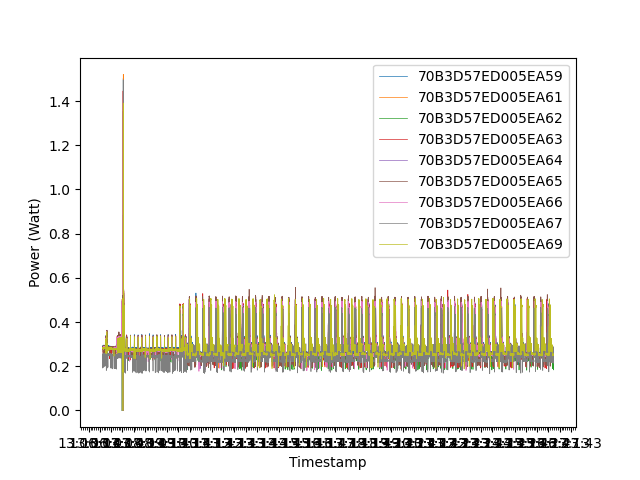

In [15]:
plt.figure()
for node_id, group in groups:
    plt.plot(group.index, group["power"], label=node_id, linewidth=0.5)

plt.xlabel("Timestamp")
plt.ylabel("Power (Watt)")
plt.gca().xaxis.set_major_locator(SecondLocator(interval=30))  # Set the major locator to display labels every 30 seconds
plt.gca().xaxis.set_minor_locator(SecondLocator(interval=5))  # Set the minor locator to display labels at millisecond level
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S')) 
#plt.gca().xaxis.set_minor_formatter(DateFormatter('%S.%f'))  
plt.legend()
plt.show()

In [16]:
groups["power"].get_group(deveui)

timestamp
2024-04-23 13:06:50.149463    0.288753
2024-04-23 13:06:50.150592    0.288143
2024-04-23 13:06:50.151721    0.288143
2024-04-23 13:06:50.152820    0.287532
2024-04-23 13:06:50.153949    0.287532
                                ...   
2024-04-23 13:26:56.250270    0.262503
2024-04-23 13:26:56.251399    0.263113
2024-04-23 13:26:56.252528    0.261892
2024-04-23 13:26:56.253657    0.261892
2024-04-23 13:26:56.254755    0.262503
Name: power, Length: 1073207, dtype: float64

## finding sync signals

In [17]:
BLINK_HIGH_MS = 200
BLINK_PRE_MS = 100
BLINK_POST_MS = 100

/home/flapkap/.local/lib/python3.10/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


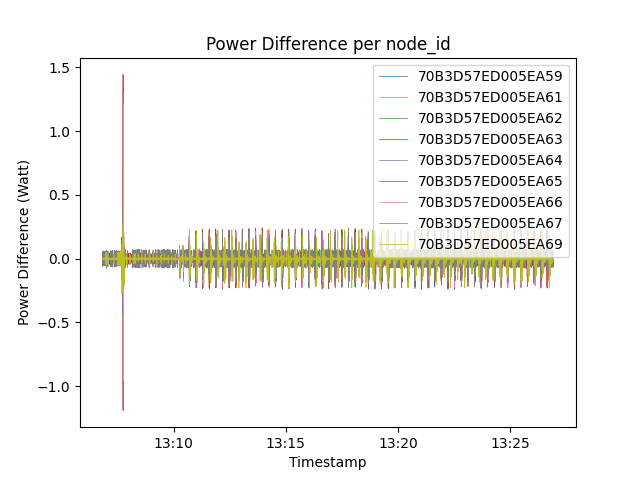

/home/flapkap/.local/lib/python3.10/site-packages/ipympl/backend_nbagg.py:279: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.manager.handle_json(content)


In [18]:
#diff of each group
power_consumption['power_diff'] = groups["power"].diff()

# single node
power_single = power_consumption[(power_consumption["node_id"] ==deveui)]
plt.figure()
for node_id, group in power_consumption.groupby("node_id"):
    plt.plot(group.index, group["power_diff"], label=node_id, linewidth=0.5)
plt.title("Power Difference per node_id")
plt.xlabel("Timestamp")
plt.ylabel("Power Difference (Watt)")
plt.legend()
plt.show()

In [19]:
rising_edge = power_consumption[power_consumption["power_diff"] > 0.1].copy()
rising_edge.loc[:,'direction'] = 'rising'
falling_edge = power_consumption[power_consumption["power_diff"] < -0.1].copy()
falling_edge.loc[:,'direction'] = 'falling'
edges = pd.concat([rising_edge, falling_edge], verify_integrity=True)
edges.sort_index(inplace=True)
edges.head()

,power,current,voltage,node_id,power_diff,direction
timestamp,,,,,,
2024-04-23 13:07:41.070326,0.444423,0.092596,4.80000,70B3D57ED005EA62,0.169711,rising
2024-04-23 13:07:41.270590,0.333928,0.069472,4.80500,70B3D57ED005EA62,-0.155060,falling
2024-04-23 13:07:41.362742,0.133083,0.028961,3.98625,70B3D57ED005EA62,-0.141629,falling
2024-04-23 13:07:41.363902,0.000000,0.000122,2.37250,70B3D57ED005EA62,-0.133083,falling
2024-04-23 13:07:41.871208,0.389481,0.080924,4.80750,70B3D57ED005EA66,0.113548,rising


In [33]:
# populate edges with next direction and timestamps to later filter out edges that are too close to each other.
# need the index as dedicated column for this to be possible as a groupby transformation
edges['timestamp'] = edges.index.copy()
edges['next_direction'] = edges.groupby('node_id')['direction'].shift(-1)
edges['next_timestamp'] = edges.groupby('node_id')['timestamp'].shift(-1)
edges.head()

,power,current,voltage,node_id,power_diff,direction,next_direction,timestamp,next_timestamp
timestamp,,,,,,,,,
2024-04-23 13:07:41.070326,0.444423,0.092596,4.80000,70B3D57ED005EA62,0.169711,rising,falling,2024-04-23 13:07:41.070326,2024-04-23 13:07:41.270590
2024-04-23 13:07:41.270590,0.333928,0.069472,4.80500,70B3D57ED005EA62,-0.155060,falling,falling,2024-04-23 13:07:41.270590,2024-04-23 13:07:41.362742
2024-04-23 13:07:41.362742,0.133083,0.028961,3.98625,70B3D57ED005EA62,-0.141629,falling,falling,2024-04-23 13:07:41.362742,2024-04-23 13:07:41.363902
2024-04-23 13:07:41.363902,0.000000,0.000122,2.37250,70B3D57ED005EA62,-0.133083,falling,rising,2024-04-23 13:07:41.363902,2024-04-23 13:07:45.011794
2024-04-23 13:07:41.871208,0.389481,0.080924,4.80750,70B3D57ED005EA66,0.113548,rising,rising,2024-04-23 13:07:41.871208,2024-04-23 13:07:41.872368


In [39]:
# now to filter out edges that are too close to each other or too far apart. We add 10% tolerance

# filter out edges that are too close to each other or too far apart. We add 10% tolerance
edges = edges[(edges['direction'] == "rising") & (edges['next_direction'] == "falling") & ((edges['next_timestamp'] - edges.index < pd.Timedelta(milliseconds=BLINK_HIGH_MS + (BLINK_HIGH_MS/10)))  & (edges['next_timestamp'] - edges.index > pd.Timedelta(milliseconds=BLINK_HIGH_MS - (BLINK_HIGH_MS/10))))]
edges.head()

,power,current,voltage,node_id,power_diff,direction,next_direction,timestamp,next_timestamp
timestamp,,,,,,,,,
2024-04-23 13:07:41.070326,0.444423,0.092596,4.80000,70B3D57ED005EA62,0.169711,rising,falling,2024-04-23 13:07:41.070326,2024-04-23 13:07:41.270590
2024-04-23 13:07:41.872368,0.493871,0.102706,4.80625,70B3D57ED005EA66,0.104390,rising,falling,2024-04-23 13:07:41.872368,2024-04-23 13:07:42.072265
2024-04-23 13:07:42.639429,0.499976,0.100630,4.96500,70B3D57ED005EA63,0.101338,rising,falling,2024-04-23 13:07:42.639429,2024-04-23 13:07:42.838594
2024-04-23 13:07:43.385092,0.421225,0.086736,4.85625,70B3D57ED005EA61,0.145292,rising,falling,2024-04-23 13:07:43.385092,2024-04-23 13:07:43.585783
2024-04-23 13:07:43.397011,0.464569,0.096259,4.82375,70B3D57ED005EA67,0.156891,rising,falling,2024-04-23 13:07:43.397011,2024-04-23 13:07:43.596511


In [40]:
## add sync signal start and end times
edges.loc[:, 'sync_start'] = edges.index - pd.Timedelta(milliseconds=100)
edges.loc[:, 'sync_end'] = edges.next_timestamp + pd.Timedelta(milliseconds=100)
edges.head()

,power,current,voltage,node_id,power_diff,direction,next_direction,timestamp,next_timestamp,sync_start,sync_end
timestamp,,,,,,,,,,,
2024-04-23 13:07:41.070326,0.444423,0.092596,4.80000,70B3D57ED005EA62,0.169711,rising,falling,2024-04-23 13:07:41.070326,2024-04-23 13:07:41.270590,2024-04-23 13:07:40.970326,2024-04-23 13:07:41.370590
2024-04-23 13:07:41.872368,0.493871,0.102706,4.80625,70B3D57ED005EA66,0.104390,rising,falling,2024-04-23 13:07:41.872368,2024-04-23 13:07:42.072265,2024-04-23 13:07:41.772368,2024-04-23 13:07:42.172265
2024-04-23 13:07:42.639429,0.499976,0.100630,4.96500,70B3D57ED005EA63,0.101338,rising,falling,2024-04-23 13:07:42.639429,2024-04-23 13:07:42.838594,2024-04-23 13:07:42.539429,2024-04-23 13:07:42.938594
2024-04-23 13:07:43.385092,0.421225,0.086736,4.85625,70B3D57ED005EA61,0.145292,rising,falling,2024-04-23 13:07:43.385092,2024-04-23 13:07:43.585783,2024-04-23 13:07:43.285092,2024-04-23 13:07:43.685783
2024-04-23 13:07:43.397011,0.464569,0.096259,4.82375,70B3D57ED005EA67,0.156891,rising,falling,2024-04-23 13:07:43.397011,2024-04-23 13:07:43.596511,2024-04-23 13:07:43.297011,2024-04-23 13:07:43.696511


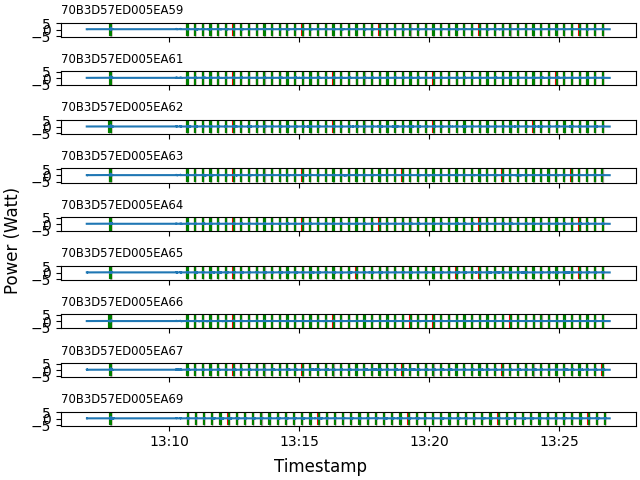

In [44]:
groups_by_node_id = power_consumption.groupby('node_id')
edges_by_node_id = edges.groupby('node_id')
fig, axs = plt.subplots(len(groups_by_node_id), 1, sharex=True, sharey=True, layout='constrained')

fig.supxlabel("Timestamp")
fig.supylabel("Power (Watt)")
for ((node_id, group), ax) in zip(groups_by_node_id, axs):
    edges_grouped = edges_by_node_id.get_group(node_id)
    ax.vlines(edges_grouped['timestamp'], ymin=-5, ymax=5, color='red')
    ax.vlines(edges_grouped['next_timestamp'], ymin=-5, ymax=5, color='green')
    for row in edges_by_node_id.get_group(node_id).itertuples():
        ax.axvspan(row.sync_start, row.sync_end, color='grey', alpha=0.5)
    ax.plot(group.index, group["power"], label=node_id)
    ax.set_title(node_id, fontsize='small', loc='left')


plt.show()

In [26]:
# every loop starts with 2 sync signals right after each other
# find all sync signals where the next start is very close to previous end
edges['next_sync_start'] = edges['sync_start'].shift(-1)
edges['next_sync_end'] = edges['sync_end'].shift(-1)
loops = edges[(abs(edges['sync_end'] - edges['next_sync_start']) < pd.Timedelta(milliseconds=500))][['node_id', 'sync_start', 'next_sync_end']].copy()
loops.rename(columns={'sync_start': 'loop_signal_start', 'next_sync_end': 'loop_signal_end'}, inplace=True)
loops['loop_num'] = range(len(loops))
loops.head()

,node_id,loop_signal_start,loop_signal_end,loop_num
timestamp,,,,
2024-04-23 13:07:41.070326,70B3D57ED005EA62,2024-04-23 13:07:40.970326,2024-04-23 13:07:42.172265,0
2024-04-23 13:07:41.872368,70B3D57ED005EA66,2024-04-23 13:07:41.772368,2024-04-23 13:07:42.938594,1
2024-04-23 13:10:42.063288,70B3D57ED005EA59,2024-04-23 13:10:41.963288,2024-04-23 13:10:42.751382,2
2024-04-23 13:10:42.465615,70B3D57ED005EA59,2024-04-23 13:10:42.365615,2024-04-23 13:10:43.005310,3
2024-04-23 13:10:42.705687,70B3D57ED005EA69,2024-04-23 13:10:42.605687,2024-04-23 13:10:43.409163,4


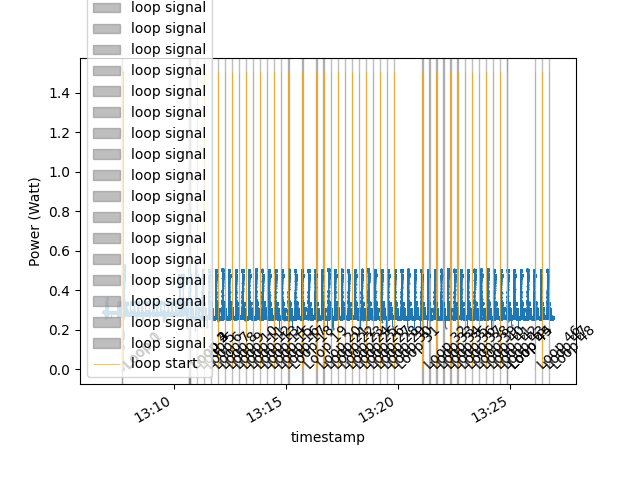

In [27]:
plt.figure()
power_single['power'].plot(style='.',markersize=1, label="power")
power_single['power'].plot(linewidth=0.5, color='tab:blue', label="power")
plt.ylabel("Power (Watt)")

## add sync signal indication
for row in loops.itertuples():
    plt.axvspan(row.loop_signal_start, row.loop_signal_end, color='tab:gray', alpha=0.5, label="loop signal")
    plt.text(row.Index, 0, f"Loop {row.loop_num}", rotation=45)
# plt.vlines(edges.index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5, label="rising edge")
# plt.vlines(edges['next_timestamp'], ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="green", linewidth=0.5, label="falling edge")
plt.vlines(loops.index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="orange", linewidth=0.5, label="loop start")

plt.legend()
plt.show()

In [28]:
# 'TIMINGS> Loop: 0, Sync: 806 ms, Load: 40 ms, sensor init: 10 ms, env init: 0 ms, net init: 5216 ms, Collect: -1 ms, Exec: -1 ms, Send: 5119 ms, save config: 2646 ms, Sleep: 9 s\n'
query = """
SELECT 
    node_id,
    timestamp,
    regexp_extract(message, 'Loop: (-?[0-9]+)',1) as loop_num,
    regexp_extract(message, '.*Sync: (-?[0-9]+)',1) as sync_time_ms,
    regexp_extract(message, '.*Load: (-?[0-9]+)',1) as load_time_ms,
    regexp_extract(message, '.*sensor init: (-?[0-9]+)',1) as sensor_init_time_ms,
    regexp_extract(message, '.*env init: (-?[0-9]+)',1) as env_init_time_ms,
    regexp_extract(message, '.*net init: (-?[0-9]+)',1) as net_init_time_ms,
    --regexp_extract(message, '.*Listen: (-?[0-9]+)',1) as listen_time_ms,
    regexp_extract(message, '.*Collect: (-?[0-9]+)',1) as collect_time_ms,
    regexp_extract(message, '.*Exec: (-?[0-9]+)',1) as exec_time_ms,
    regexp_extract(message, '.*Send: (-?[0-9]+)',1) as send_time_ms,
    regexp_extract(message, '.*save config: (-?[0-9]+)',1) as save_config_time_ms,
    regexp_extract(message, '.*Sleep: (-?[0-9]+)',1) as sleep_time_s
FROM expdb.Trace
WHERE message LIKE 'TIMINGS>%'
"""
timings = %sql {{query}}
timings.head()

Running query in 'duckdb'

,node_id,timestamp,loop_num,sync_time_ms,load_time_ms,sensor_init_time_ms,env_init_time_ms,net_init_time_ms,collect_time_ms,exec_time_ms,send_time_ms,save_config_time_ms,sleep_time_s
0,70B3D57ED005EA61,2024-04-23 13:10:35.760513,0,806,29,25,0,158083,-1,-1,7890,701,6
1,70B3D57ED005EA63,2024-04-23 13:10:35.761175,0,806,29,25,0,158066,-1,-1,7890,702,6
2,70B3D57ED005EA59,2024-04-23 13:10:35.769310,0,805,30,25,0,158258,-1,-1,7890,710,6
3,70B3D57ED005EA69,2024-04-23 13:10:36.411649,0,806,29,26,0,158122,-1,-1,7895,1344,6
4,70B3D57ED005EA61,2024-04-23 13:10:49.499617,1,806,25,25,1,56,-1,-1,4078,536,10


In [29]:
# since duckdb return all columns as object we need to change types before we can merge
timings[['loop_num', 'sync_time_ms', 'load_time_ms', 'sensor_init_time_ms', 'env_init_time_ms', 'net_init_time_ms', 'collect_time_ms', 'exec_time_ms', 'send_time_ms', 'save_config_time_ms', 'sleep_time_s']] = timings[['loop_num', 'sync_time_ms', 'load_time_ms', 'sensor_init_time_ms', 'env_init_time_ms', 'net_init_time_ms', 'collect_time_ms', 'exec_time_ms', 'send_time_ms', 'save_config_time_ms', 'sleep_time_s']].apply(pd.to_numeric)

# .. and merge. here we need to reset index first, since df.merge doesnt preserve index
loops = loops.reset_index().merge(timings, on=['node_id', 'loop_num']).set_index('loop_signal_start')
loops.head()

,timestamp_x,node_id,loop_signal_end,loop_num,timestamp_y,sync_time_ms,load_time_ms,sensor_init_time_ms,env_init_time_ms,net_init_time_ms,collect_time_ms,exec_time_ms,send_time_ms,save_config_time_ms,sleep_time_s
loop_signal_start,,,,,,,,,,,,,,,
2024-04-23 13:10:41.963288,2024-04-23 13:10:42.063288,70B3D57ED005EA59,2024-04-23 13:10:42.751382,2,2024-04-23 13:11:07.261630,806,25,25,0,56,-1,-1,4078,542,10
2024-04-23 13:10:42.365615,2024-04-23 13:10:42.465615,70B3D57ED005EA59,2024-04-23 13:10:43.005310,3,2024-04-23 13:11:25.009919,806,25,25,0,57,-1,-1,4079,542,10
2024-04-23 13:10:42.605687,2024-04-23 13:10:42.705687,70B3D57ED005EA69,2024-04-23 13:10:43.409163,4,2024-04-23 13:11:47.879431,806,25,26,0,56,0,121,4036,1278,10
2024-04-23 13:11:01.472671,2024-04-23 13:11:01.572671,70B3D57ED005EA69,2024-04-23 13:11:02.276148,5,2024-04-23 13:12:06.744731,806,25,26,0,56,0,121,4035,1277,10
2024-04-23 13:11:20.339686,2024-04-23 13:11:20.439686,70B3D57ED005EA69,2024-04-23 13:11:21.142034,6,2024-04-23 13:12:25.612221,806,25,26,0,57,0,121,4036,1278,10


Locator attempting to generate 1332 ticks ([19836.54571759259, ..., 19836.561122685187]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1332 ticks ([19836.54571759259, ..., 19836.561122685187]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1332 ticks ([19836.54571759259, ..., 19836.561122685187]), which exceeds Locator.MAXTICKS (1000).


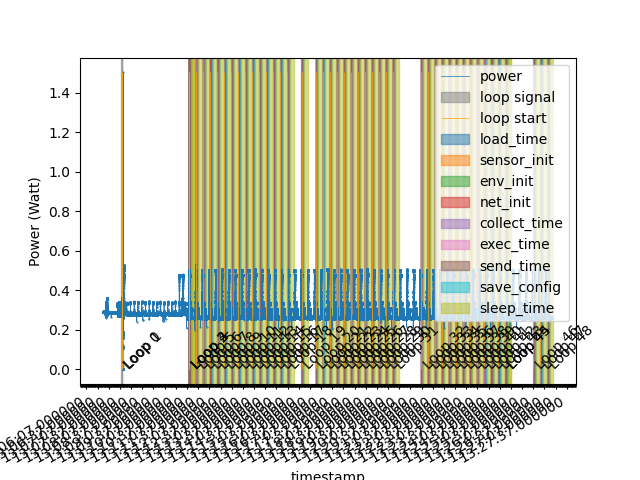

In [30]:

loops["start_time"] = loops.index
loops["sync_start"] = loops["start_time"]
loops["sync_end"] = loops["sync_start"] + pd.to_timedelta(loops["sync_time_ms"], unit="ms")
loops["load_start"] = loops["sync_end"]
loops["load_end"] = loops["load_start"] + pd.to_timedelta(loops["load_time_ms"], unit="ms")
loops["sensor_init_start"] = loops["load_end"]
loops["sensor_init_end"] = loops["sensor_init_start"] + pd.to_timedelta(loops["sensor_init_time_ms"], unit="ms")
loops["env_init_start"] = loops["sensor_init_end"]
loops["env_init_end"] = loops["env_init_start"] + pd.to_timedelta(loops["env_init_time_ms"], unit="ms")
loops["net_init_start"] = loops["env_init_end"]
loops["net_init_end"] = loops["net_init_start"] + pd.to_timedelta(loops["net_init_time_ms"], unit="ms")
loops["collect_time_start"] = loops["net_init_end"]
loops["collect_time_end"] = loops["collect_time_start"] +pd.to_timedelta(loops["collect_time_ms"], unit="ms")
loops["exec_start"] = loops["collect_time_end"]
loops["exec_end"] = loops["exec_start"] + pd.to_timedelta(loops["exec_time_ms"], unit="ms")
loops["send_start"] = loops["exec_end"]
loops["send_end"] = loops["send_start"] +pd.to_timedelta(loops["send_time_ms"], unit="ms")
loops["save_config_start"] = loops["send_end"]
loops["save_config_end"] = loops["save_config_start"] + pd.to_timedelta(loops["save_config_time_ms"], unit="ms")
loops["sleep_start"] = loops["save_config_end"]
loops["sleep_end"] = loops["sleep_start"] + pd.to_timedelta(loops["sleep_time_s"], unit="s")

loops.replace(-1,0) # remove -1 values. They show up if the time measurement is not available

for row in loops.itertuples():
    plt.axvspan(row.load_start, row.load_end, color='tab:blue', alpha=0.5, label="load_time")
    plt.axvspan(row.sensor_init_start, row.sensor_init_end, color='tab:orange', alpha=0.5, label="sensor_init")
    plt.axvspan(row.env_init_start, row.env_init_end, color='tab:green', alpha=0.5, label="env_init")
    plt.axvspan(row.net_init_start, row.net_init_end, color='tab:red', alpha=0.5, label="net_init")
    plt.axvspan(row.collect_time_start, row.collect_time_end, color='tab:purple', alpha=0.5, label="collect_time")
    plt.axvspan(row.exec_start, row.exec_end, color='tab:pink', alpha=0.5, label="exec_time")
    plt.axvspan(row.send_start, row.send_end, color='tab:brown', alpha=0.5, label="send_time")
    plt.axvspan(row.save_config_start, row.save_config_end, color='tab:cyan', alpha=0.5, label="save_config")
    plt.axvspan(row.sleep_start, row.sleep_end, color='tab:olive', alpha=0.5, label="sleep_time")
# this to remove duplicate labels https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.gca().xaxis.set_major_locator(SecondLocator(interval=30))
plt.gca().xaxis.set_minor_locator(SecondLocator(interval=1))

plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S.%f'))  # Set the date format for the tick labels
plt.show()

## Add events if any

In [ ]:
# get all relevant frame-events
%sql send_frame_start << select * from Trace WHERE message LIKE '%send frame%'
%sql send_frame_end << select * from Trace WHERE message LIKE '%Transmission completed%'
%sql receive_frame_start << select * from Trace WHERE message LIKE '%RX started%'
%sql receive_frame_end << select * from Trace WHERE message LIKE '%received something%'

Locator attempting to generate 1332 ticks ([19836.54571759259, ..., 19836.561122685187]), which exceeds Locator.MAXTICKS (1000).


In [ ]:
#drop first row of send_frame_end and receive_frame_start since thats from the join procedure
send_frame_end = send_frame_end.iloc[1:]
receive_frame_start = receive_frame_start.iloc[1:]

# confirm the 2 pairs of start/end all have the same length
assert len(send_frame_start) == len(send_frame_end), f"send frame event mismatch. start {len(send_frame_start)}, end { len(send_frame_end)}"
assert len(receive_frame_start) == len(receive_frame_end), f"receive frame event mismatch  {len(receive_frame_start)}, end { len(receive_frame_end)}"

Locator attempting to generate 1326 ticks ([19803.61946759259, ..., 19803.63480324074]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1326 ticks ([19803.61946759259, ..., 19803.63480324074]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1326 ticks ([19803.61946759259, ..., 19803.63480324074]), which exceeds Locator.MAXTICKS (1000).


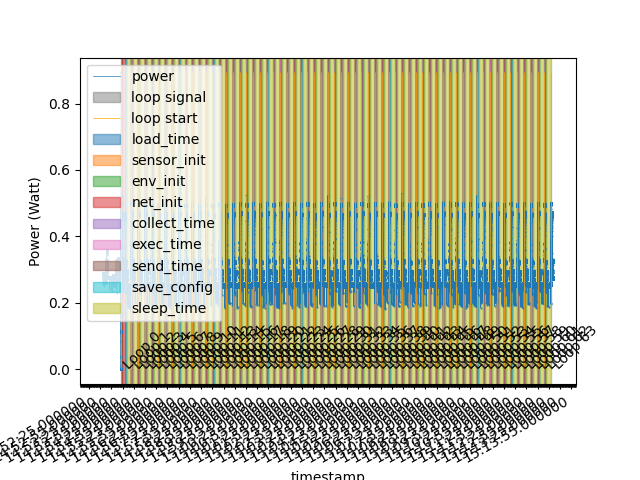

In [ ]:
# add send and receive columns to plot

for send_start_row, send_end_row in zip(send_frame_start.itertuples(), send_frame_end.itertuples()):
    start_time = send_start_row.timestamp
    end_time = send_end_row.timestamp
    plt.axvspan(start_time, end_time, color='tab:pink', alpha=0.5, label="send_events")

for receive_frame_start, receive_frame_end in zip(receive_frame_start.itertuples(), receive_frame_end.itertuples()):
    start_time = receive_frame_start.timestamp
    end_time = receive_frame_end.timestamp
    plt.axvspan(start_time, end_time, color='tab:brown', alpha=0.5, label="receive_events")


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

In [ ]:
%sql SELECT * from Content_Message

,content_message_id,frame_counter,frame_port,frame_payload
0,2,-1,1,CmwKagpoCmQKAggBCgIQAAoCCAAKAhAICgIICgoCCAEKAh...
1,3,0,2,PDM=
2,4,-1,1,CmwKagpoCmQKAggBCgIQAAoCCAAKAhAICgIICgoCCAEKAh...


In [ ]:
%%sql
SELECT
    through_gateway,
    gateway_received_at,
    app_received_at,
    rssi,
    snr,
    bandwidth,
    frequency,
    consumed_airtime_s,
    spreading_factor,
    coding_rate,
    frame_counter,
    frame_port,
    frame_payload,
    from_base64(frame_payload) as decoded_payload,
    related_node,
    network_received_at
FROM
    expdb.Uplink_Message,
    expdb.Content_Message,
    expdb.Message 
WHERE
    expdb.Uplink_Message.uplink_message_id = expdb.Message.message_id AND
    expdb.Content_Message.content_message_id = expdb.Message.message_id

,through_gateway,gateway_received_at,app_received_at,rssi,snr,bandwidth,frequency,consumed_airtime_s,spreading_factor,coding_rate,frame_counter,frame_port,frame_payload,decoded_payload,related_node,network_received_at
0,gw-tetech-test,2024-03-21 15:54:02,2024-03-21 15:54:02.836051,-123,-4,125000,867700000,1.155072,SF12,4/5,0,2,PDM=,"[60, 51]",70B3D57ED005EA59,2024-03-21 15:54:02.631244


## Calculate Total Energy Consumed per region

In [ ]:
def calc_energy_consumed(df: pd.DataFrame):
    # Assume df have columns "power" and index of "timestamp" type.
    # create a copy of the dataframe with only index and power
    if len(df) == 0:
        return 0
    power = df[["power"]]

    #power["power_diff"] = power.diff().shift(-1) #  current - previous, shifted one back so it becomes next - current. i.e. current + diff = next
    power["time_diff"] = abs(power.index.diff(-1)) # abs(next-current)
    us_per_s = 1_000_000
    power["time_diff_s"] = power["time_diff"].dt.microseconds / us_per_s # get timediff in fractions of a second
    power = power.drop(power.index[-1]) # drop last row since it has no next and therefore should be NaN
    return sum(power["power"] * power["time_diff_s"]) # returns the sum of power times fractions of a second. Since power is in W and time_diff_s is in seconds it is in W*s or J

calc_energy_consumed(power_single)
power_single.head()

,power,current,voltage,node_id,power_diff
timestamp,,,,,
2024-03-21 14:53:01.565424,0.280206,0.057702,4.86000,70B3D57ED005EA59,NaN
2024-03-21 14:53:01.566522,0.281427,0.057824,4.86125,70B3D57ED005EA59,0.001221
2024-03-21 14:53:01.567621,0.282038,0.057946,4.86375,70B3D57ED005EA59,0.000611
2024-03-21 14:53:01.568689,0.282648,0.058141,4.86125,70B3D57ED005EA59,0.000610
2024-03-21 14:53:01.569787,0.280817,0.057824,4.86000,70B3D57ED005EA59,-0.001831


In [ ]:
# loops contain the start and end times of each activity, so loop over loops and calculate the energy for each activity
def calc_energy_consumed_per_activity(series_loops: pd.Series) -> pd.Series:
    return pd.Series({
        "total": calc_energy_consumed(power_single.loc[series_loops.name:series_loops["sleep_end"]]),
        "loop signal": calc_energy_consumed(power_single.loc[series_loops.name:series_loops["loop_signal_end"]]),
        "total without loop signal": calc_energy_consumed(power_single.loc[series_loops["loop_signal_end"]:series_loops["sleep_end"]]),
        "load config": calc_energy_consumed(power_single.loc[series_loops["load_start"]:series_loops["load_end"]]),
        "sensor init": calc_energy_consumed(power_single.loc[series_loops["sensor_init_start"]:series_loops["sensor_init_end"]]),
        "env init": calc_energy_consumed(power_single.loc[series_loops["env_init_start"]:series_loops["env_init_end"]]),
        "net init": calc_energy_consumed(power_single.loc[series_loops["net_init_start"]:series_loops["net_init_end"]]),
        "sensor collect": calc_energy_consumed(power_single.loc[series_loops["collect_time_start"]:series_loops["collect_time_end"]]),
        "query execution": calc_energy_consumed(power_single.loc[series_loops["exec_start"]:series_loops["exec_end"]]),
        "send": calc_energy_consumed(power_single.loc[series_loops["send_start"]:series_loops["send_end"]]),
        "save config": calc_energy_consumed(power_single.loc[series_loops["save_config_start"]:series_loops["save_config_end"]]),
        "sleep": calc_energy_consumed(power_single.loc[series_loops["sleep_start"]:series_loops["sleep_end"]]),
    })
energy_consumed = loops.apply(calc_energy_consumed_per_activity, axis=1)
energy_consumed_summary = energy_consumed.describe()
energy_consumed_summary

,total,loop signal,total without loop signal,load config,sensor init,env init,net init,sensor collect,query execution,send,save config,sleep
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.0,63.000000,63.0,63.000000,63.000000,63.000000,63.000000
mean,4.613173,0.308052,4.304821,0.006006,0.002187,0.0,0.058515,0.0,0.033767,1.457582,0.154975,2.588750
std,0.317126,0.001721,0.316688,0.000181,0.000045,0.0,0.337476,0.0,0.004333,0.015767,0.001181,0.014311
min,4.537417,0.304883,4.230253,0.005888,0.002144,0.0,0.015727,0.0,0.000000,1.348790,0.151697,2.563727
25%,4.554211,0.306790,4.247249,0.005934,0.002169,0.0,0.015865,0.0,0.034118,1.452284,0.153929,2.577092
50%,4.570849,0.307865,4.265225,0.005974,0.002177,0.0,0.015956,0.0,0.034289,1.457793,0.154707,2.590217
75%,4.592372,0.309746,4.283756,0.006013,0.002197,0.0,0.016087,0.0,0.034608,1.466174,0.155964,2.599063
max,7.084684,0.311114,6.773308,0.007277,0.002510,0.0,2.694629,0.0,0.034794,1.473193,0.156979,2.617185


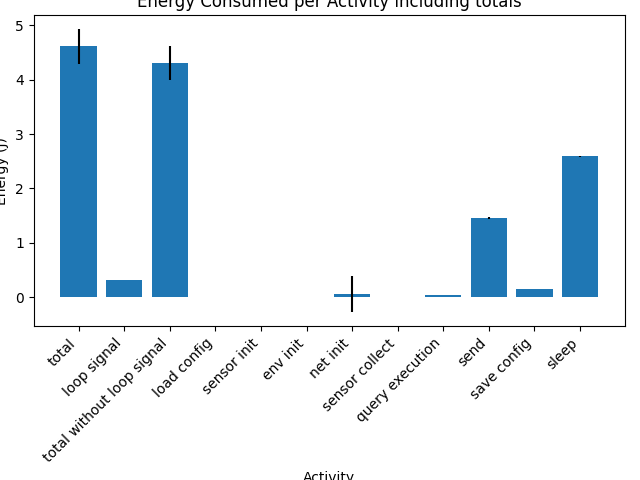

In [ ]:
# plot barchart with stddev error bars
plt.figure()
plt.bar(energy_consumed_summary.columns, energy_consumed_summary.loc["mean"], yerr=energy_consumed_summary.loc["std"])
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.xlabel("Activity")
plt.ylabel("Energy (J)")
plt.title("Energy Consumed per Activity including totals")
plt.show()

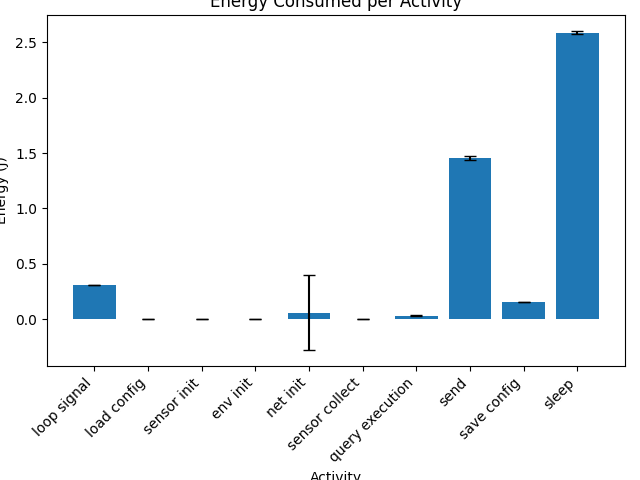

In [ ]:
# plot barchart without totals 
plt.figure()
energy_consumed_summary_no_totals = energy_consumed_summary.drop(["total", "total without loop signal"], axis=1)
plt.bar(energy_consumed_summary_no_totals.columns, energy_consumed_summary_no_totals.loc["mean"], yerr=energy_consumed_summary_no_totals.loc["std"], capsize=4)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.xlabel("Activity")
plt.ylabel("Energy (J)")
plt.title("Energy Consumed per Activity")
plt.show()

In [ ]:
# plot barchart without totals and without the 0th loop

energy_consumed_without_0th_loop = loops.iloc[1:].apply(calc_energy_consumed_per_activity, axis=1)
#energy_consumed_without_0th_loop
plt.figure()
energy_consumed_summary_no_totals_no_0_loop_summary = energy_consumed_without_0th_loop.drop(["total", "total without loop signal"], axis=1).describe()
plt.bar(energy_consumed_summary_no_totals_no_0_loop_summary.columns, energy_consumed_summary_no_totals_no_0_loop_summary.loc["mean"], yerr=energy_consumed_summary_no_totals_no_0_loop_summary.loc["std"], capsize=4)
plt.xticks(rotation=20, ha="right")

plt.xlabel("Activity")
plt.ylabel("Energy (J)")
plt.title("Energy Consumed per Activity without connection establishment loop")
plt.show()

NameError: name 'loops' is not defined